#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    """
    X : np.ndarray, shape (N, K) - матрица признаков
    y : np.ndarray, shape (N,) - метки (+1 или -1)
    w : List[float] - веса модели
    w0 : float - смещение
    gamma : float - коэффициент L1-регуляризации
    beta : float - коэффициент L2-регуляризации
    """
    w = np.array(w)
    N = X.shape[0]

    # линейная комбинация
    z = X.dot(w) + w0

    # логистическая часть
    log_loss = np.mean(np.log(1 + np.exp(-y * z)))

    # L1 и L2 регуляризация
    l1_penalty = gamma * np.sum(np.abs(w))
    l2_penalty = beta * np.sum(w**2)

    return log_loss + l1_penalty + l2_penalty

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    """
    X : np.ndarray, shape (N, K) - матрица признаков
    y : np.ndarray, shape (N,) - метки (+1 или -1)
    w : List[float] - веса модели
    w0 : float - смещение
    gamma : float - коэффициент L1-регуляризации
    beta : float - коэффициент L2-регуляризации

    Returns:
        grad_w : List[float] - градиенты по весам
        grad_w0 : float - градиент по смещению
    """
    w = np.array(w)
    N = X.shape[0]

    z = X.dot(w) + w0
    exp_term = np.exp(y * z)

    # коэффициент перед X в градиенте
    coeff = -y / (1 + exp_term)

    # градиент по весам
    grad_w = (X.T @ coeff) / N + gamma * np.sign(w) + 2 * beta * w

    # градиент по смещению
    grad_w0 = np.mean(coeff)

    return grad_w.tolist(), float(grad_w0)

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        """
        beta: коэффициент L2-регуляризации
        gamma: коэффициент L1-регуляризации
        lr: шаг обучения (learning rate)
        tolerance: минимальное изменение функции потерь для остановки
        max_iter: максимальное число итераций
        random_state: генератор случайных чисел
        """
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        N, K = X.shape

        # инициализация весов случайно
        self.w = np.random.randn(K) * 0.01
        self.w0 = 0.0

        prev_loss = np.inf
        self.loss_history = []

        for iteration in range(self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            self.w -= self.lr * np.array(grad_w)
            self.w0 -= self.lr * grad_w0

            current_loss = loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            self.loss_history.append(current_loss)

            if abs(prev_loss - current_loss) < self.tolerance:
                break
            prev_loss = current_loss

        return self

    def predict(self, X):
        """
        Возвращает метки класса: +1 или -1
        """
        prob = self.predict_proba(X)
        return np.where(prob >= 0.5, 1, -1)

    def predict_proba(self, X):
        """
        Возвращает вероятность принадлежности к классу +1
        """
        z = X.dot(self.w) + self.w0
        prob = 1 / (1 + np.exp(-z))
        return prob

In [7]:
X = np.array([[1, 2], [3, 4], [5, 6]])
y = np.array([1, -1, 1])

model = Logit(beta=0.5, gamma=0.5, lr=0.1, max_iter=5000)
model.fit(X, y)

print("Предсказания:", model.predict(X))
print("Вероятности:", model.predict_proba(X))

Предсказания: [1 1 1]
Вероятности: [0.69580618 0.73052473 0.76263253]


In [8]:
# этот код менять не надо! Не украсть мои данные.
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [9]:
def plot_decision_boundary(model, X, y):
    """
    Отрисовка объектов, их меток и разделяющей гиперплоскости
    model: обученный объект Logit
    X: np.ndarray, shape (N, 2) - двумерные признаки
    y: np.ndarray, shape (N,) - метки (+1 или -1)
    """
    # Проверка, что у нас 2 признака
    assert X.shape[1] == 2, "Функция работает только с двумерными данными"

    # Создаем сетку для отрисовки границы
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Получаем предсказания вероятности для каждой точки сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Рисуем контур границы решений
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)

    # Рисуем сами объекты
    plt.scatter(X[y==1, 0], X[y==1, 1], c='beige', label='+1')
    plt.scatter(X[y==-1, 0], X[y==-1, 1], c='black', label='-1')

    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title("Decision Boundary of Logistic Regression")
    plt.legend()
    plt.show()

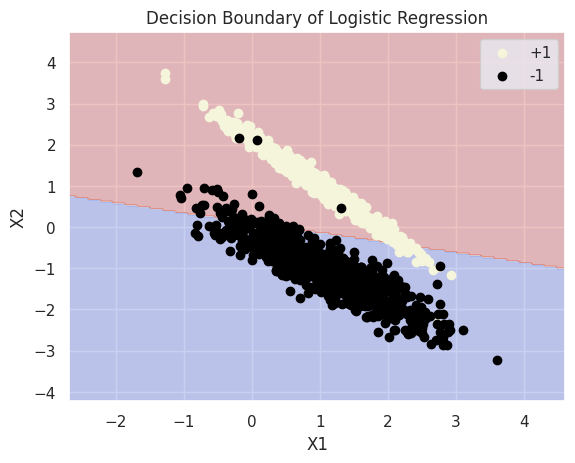

In [10]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [11]:
def plot_loss_history(model):
    """
    Рисует график изменения функции потерь по итерациям
    model: обученный объект Logit
    """
    if not hasattr(model, 'loss_history'):
        raise ValueError("Модель не содержит историю потерь. Добавьте сохранение loss_history при fit().")

    plt.plot(model.loss_history, marker='o')
    plt.xlabel("Итерация")
    plt.ylabel("Значение функции потерь")
    plt.title("История изменения функции потерь")
    plt.grid(True)
    plt.show()

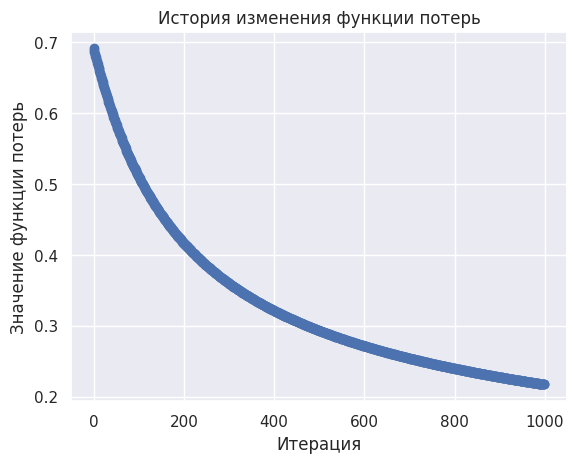

In [12]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    Kernel     C  Accuracy  Precision    Recall        F1   AUC-ROC
0   linear   0.1  0.994444   0.992395  0.996183  0.994286  0.998572
1   linear   1.0  0.994444   0.992395  0.996183  0.994286  0.998888
2   linear  10.0  0.994444   0.992395  0.996183  0.994286  0.998957
3      rbf   0.1  0.994444   0.992395  0.996183  0.994286  0.998902
4      rbf   1.0  0.994444   0.992395  0.996183  0.994286  0.998545
5      rbf  10.0  0.994444   0.992395  0.996183  0.994286  0.994961
6     poly   1.0  0.994444   0.992395  0.996183  0.994286  0.994646
7     poly   5.0  0.994444   0.992395  0.996183  0.994286  0.994206
8  sigmoid   1.0  0.940741   0.942308  0.935115  0.938697  0.966692


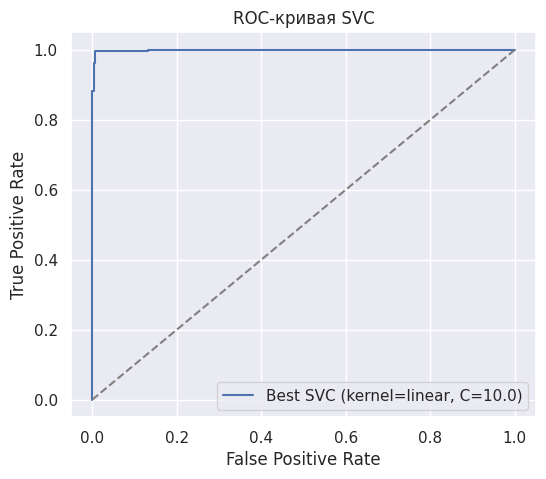

In [14]:
# Для бинарных меток SVC ожидает 0/1, не -1/1
y_train_bin = (y_train == 1).astype(int)
y_test_bin = (y_test == 1).astype(int)

# Разные конфигурации моделей
configs = [
    ('linear', 0.1),
    ('linear', 1),
    ('linear', 10),
    ('rbf', 0.1),
    ('rbf', 1),
    ('rbf', 10),
    ('poly', 1),
    ('poly', 5),
    ('sigmoid', 1)
]

results = []

for kernel, C in configs:
    model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
    model.fit(X_train, y_train_bin)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Метрики
    acc = accuracy_score(y_test_bin, y_pred)
    prec = precision_score(y_test_bin, y_pred)
    rec = recall_score(y_test_bin, y_pred)
    f1 = f1_score(y_test_bin, y_pred)
    auc = roc_auc_score(y_test_bin, y_proba)

    results.append({
        'Kernel': kernel,
        'C': C,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1': f1,
        'AUC-ROC': auc
    })

# Сводная таблица
results_df = pd.DataFrame(results)
print(results_df)

# Визуализация ROC для лучшей модели
best_model_idx = results_df['AUC-ROC'].idxmax()
best_kernel = results_df.loc[best_model_idx, 'Kernel']
best_C = results_df.loc[best_model_idx, 'C']

best_model = SVC(kernel=best_kernel, C=best_C, probability=True, random_state=42)
best_model.fit(X_train, y_train_bin)
y_proba_best = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test_bin, y_proba_best)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'Best SVC (kernel={best_kernel}, C={best_C})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая SVC')
plt.legend()
plt.grid(True)
plt.show()

#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [ ]:
class HingeLossClassifier:
    def __init__(self, lr=0.01, lambda_reg=0.01, max_iter=1000, tolerance=1e-5, random_state=42):
        """
        lr: скорость обучения
        lambda_reg: коэффициент L2-регуляризации
        max_iter: количество итераций SGD
        tolerance: критерий остановки
        """
        self.lr = lr
        self.lambda_reg = lambda_reg
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.random_state = random_state
        self.w = None
        self.w0 = None

    def fit(self, X, y):
        np.random.seed(self.random_state)
        N, K = X.shape
        self.w = np.random.randn(K) * 0.01
        self.w0 = 0.0

        prev_loss = np.inf
        self.loss_history = []

        for _ in range(self.max_iter):
            # Линейная комбинация
            margins = y * (X @ self.w + self.w0)

            # Потери hinge
            losses = np.maximum(0, 1 - margins)
            loss = np.mean(losses) + self.lambda_reg * np.sum(self.w ** 2)
            self.loss_history.append(loss)

            # Градиенты
            mask = (margins < 1).astype(float)
            grad_w = -np.mean((y * mask)[:, np.newaxis] * X, axis=0) + 2 * self.lambda_reg * self.w
            grad_w0 = -np.mean(y * mask)

            # Обновление
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            # Проверка сходимости
            if abs(prev_loss - loss) < self.tolerance:
                break
            prev_loss = loss

    def predict(self, X):
        return np.where(X @ self.w + self.w0 >= 0, 1, -1)


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        self.classes_ = np.unique(y)

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes_[np.argmax(probs, axis=1)]

    def predict_proba(self, X):
        X = np.array(X)
        N = X.shape[0]
        probs = np.zeros((N, len(self.classes_)))

        for i in range(N):
            # Вычисляем расстояния от X[i] до всех точек обучающей выборки
            if self.metric == 'euclidean':
                distances = np.sqrt(np.sum((self.X_train - X[i])**2, axis=1))
            elif self.metric == 'manhattan':
                distances = np.sum(np.abs(self.X_train - X[i]), axis=1)
            else:
                raise ValueError(f"Unknown metric: {self.metric}")

            # Индексы k ближайших соседей
            nearest_idx = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_idx]

            # Подсчитываем вероятность для каждого класса
            for j, cls in enumerate(self.classes_):
                probs[i, j] = np.sum(nearest_labels == cls) / self.n_neighbors

        return probs


Accuracy: 0.9944
Precision: 0.9924
Recall: 0.9962
F1: 0.9943
AUC-ROC: 0.9944


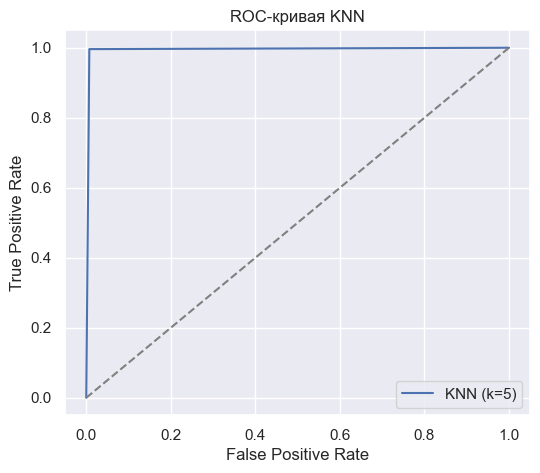

In [ ]:
# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
knn = KNNClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)

# Предсказания
y_pred = knn.predict(X_test)
probs = knn.predict_proba(X_test)

# Так как у нас классы -1 и 1, возьмём вероятность класса 1
y_proba = probs[:, np.where(knn.classes_ == 1)[0][0]]

# Переведём в 0/1 для метрик sklearn
y_test_bin = (y_test == 1).astype(int)
y_pred_bin = (y_pred == 1).astype(int)

# Метрики
acc = accuracy_score(y_test_bin, y_pred_bin)
prec = precision_score(y_test_bin, y_pred_bin)
rec = recall_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin)
auc = roc_auc_score(y_test_bin, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'KNN (k={knn.n_neighbors})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая KNN')
plt.legend()
plt.grid(True)
plt.show()

# Почти идеально

## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
# Загрузка файлов fashion mnist: отсюда https://www.kaggle.com/datasets/zalando-research/fashionmnist, т.к. не могу csv отправить в док
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')

# Объединение в один датасет
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Разделение на признаки и метки
X_full = full_df.drop('label', axis=1).values
y_full = full_df['label'].values

# переразделяем
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=0.5,  # делим 50 на 50
    random_state=42,
    stratify=y_full
)

print(f"Исходный размер: {len(full_df)}")
print(f"Обучающая выборка: {len(X_train)}")
print(f"Тестовая выборка: {len(X_test)}")

Исходный размер: 70000
Обучающая выборка: 35000
Тестовая выборка: 35000


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

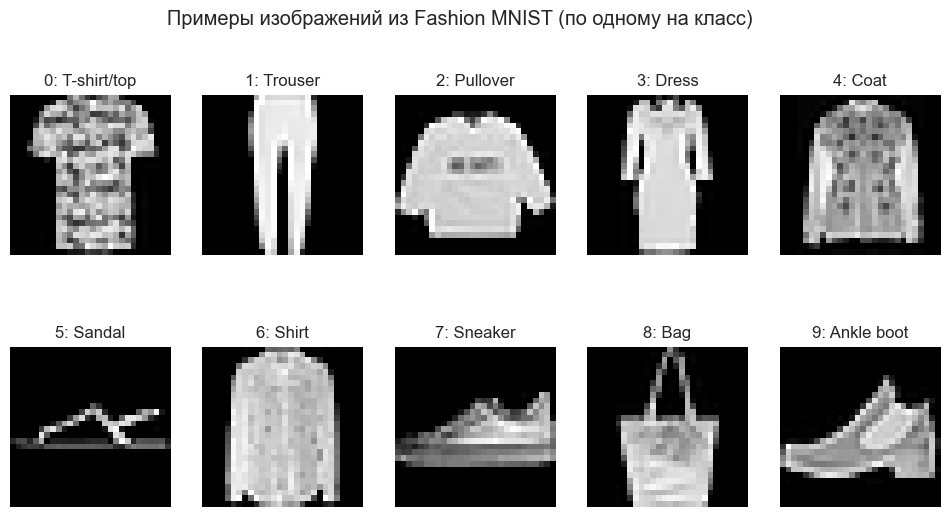

In [ ]:
# Уникальные классы от 0 до 9
classes = np.unique(y_full)

# Названия классов Fashion MNIST (для красоты графика)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 6))
for i, cls in enumerate(classes):
    # Находим индекс первого объекта этого класса и извл в изображение 28х28
    idx = np.where(y_full == cls)[0][0]
    img = X_full[idx].reshape(28, 28)

    # Визуализация
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{cls}: {class_names[cls]}")
    plt.axis('off')

plt.suptitle("Примеры изображений из Fashion MNIST (по одному на класс)")
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# Стандартизация (z-score): (x - mean) / std
X_train_std = standard_scaler.fit_transform(X_train)
X_test_std = standard_scaler.transform(X_test)

# Масштабирование в диапазон [0, 1]
X_train_mm = minmax_scaler.fit_transform(X_train)
X_test_mm = minmax_scaler.transform(X_test)

print("1) StandartScaler: среднее = %.4f, стандартное отклонение = %.4f" % (X_train_std.mean(), X_train_std.std()))
print("2) MinMaxScaler: мин = %.4f, макс = %.4f" % (X_train_mm.min(), X_train_mm.max()))

1) StandartScaler: среднее = 0.0000, стандартное отклонение = 1.0000
2) MinMaxScaler: мин = 0.0000, макс = 1.0000


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Стандартизация данных
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Подвыборка для подбора гиперпараметров
X_val, _, y_val, _ = train_test_split(X_train_pca, y_train, test_size=0.5, random_state=42, stratify=y_train)

# Определение моделей и сеток гиперпараметров с пояснением
knn = KNeighborsClassifier()
knn_params = {
    'n_neighbors': [3, 5, 7], # Модель будет чувствительна к локальным паттернам,
                              # а нечетные, чтобы избежать ничьих при голосовании
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

logreg = LogisticRegression(max_iter=200, solver='saga', n_jobs=-1, tol=1e-3)
logreg_params = {
    'C': [0.1, 1, 10],
    # 0.1 — сильная регуляризация — модель проще, меньше переобучения
    # 1 — стандартная регуляризация
    # 10 — слабая регуляризация — модель гибче
    'penalty': ['l1', 'l2']
    # L1 — помогает обнулить ненужные признаки — разреженная модель
    # L2 — лучше работает, если признаки коррелированы между собой
}

# GridSearchCV для обеих моделей
models = [
    (knn, knn_params, "KNN"),
    (logreg, logreg_params, "Logistic Regression")
]

for model, params, name in models:
    grid = GridSearchCV(
        model,
        params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_val, y_val)

    print(f"\nЛучшие параметры {name}:", grid.best_params_)
    print(f"Лучшая accuracy на валидации ({name}):", grid.best_score_)

    # Обучение лучшей модели на всей тренировочной выборке
    best_model = grid.best_estimator_
    best_model.fit(X_train_pca, y_train)
    y_pred = best_model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy {name} на тесте:", acc)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Лучшие параметры KNN: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Лучшая accuracy на валидации (KNN): 0.8371428571428572
Accuracy KNN на тесте: 0.8528
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Лучшие параметры Logistic Regression: {'C': 1, 'penalty': 'l2'}
Лучшая accuracy на валидации (Logistic Regression): 0.8233142857142857
Accuracy Logistic Regression на тесте: 0.8282571428571428


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

In [ ]:
from sklearn.linear_model import SGDClassifier

# Дано:
n_samples = 10**4
X = np.ones((n_samples, 2))  # Все признаки одинаковы
y = np.array([0] * 5000 + [1] * 5000)  # Отрицательный и положительные по 5к

# Обучаем SGD
model = SGDClassifier(loss='log_loss', random_state=42)
model.fit(X, y)

# Проверяем веса
print("Веса:", model.coef_)    # ≈ [0, 0]
print("Bias:", model.intercept_)  # ≈ [0]
print("Предсказания для всех объектов:", model.predict_proba(X)[0])

"""
ф-ла логистической регрессии: P(y=1) = sigma(w_1 x_1 + w_2 x_2 + b) = 1 / (1 + e^-(w_1 x_1 + w_2 x_2 + b)
Но х_1 и х_2 = const, const
log loss: L = -[y log(P) + (1-y) log(1-P)]
при P = 0.5: L = -log(0.5) = 0.693 в обоих случаях, где средний loss тоже = 0.693
Обучение логистической регрессией через SGD модель выдаст одинаковые вероятности для всех объектов, потому что математически это
самое оптимальное решение для минимализации log loss
"""

Веса: [[-0.00954676 -0.00954676]]
Bias: [-0.00938978]
Предсказания для всех объектов: [0.50712034 0.49287966]
